**Hajar Arrazki & Prisca Bahi & Jeffrey Verdière**

## Implementation of VIME on the mountaincar setup

In this notebook, we try to implement the VIME algorithm described in this article : https://arxiv.org/abs/1605.09674

We implement the algorithm on the mountaincar setup that we have seen in class.

No code was provided with the article. Our implementation was inspired by this github repository: https://github.com/justheuristic/vime

This notebook runs with two python files bnn.py and curiosity.py

However, we had to alter some functions because it would not run as it was. There were bugs when we wanted to run the gym environement. There were bugs in the definition of the Bayesian Neural Network as well and we had to change some functions from the curiosity.py file.

We also had to change the code for visualizing the results of the experiment.


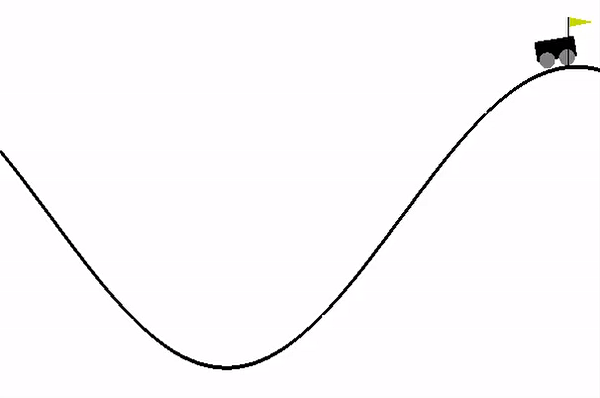
Above is a GIF of the mountain car problem where the car starts in between two hills. The goal is for the car to reach the top of the hill on the right. However, the car does not have enough engine power to reach the top of the hill by just accelerating forward. To win, the car must build momentum by swinging itself until it has enough speed to reach the flag.

In [ ]:
%load_ext autoreload
%autoreload 2

# Experiment setup
Here we install and setup all the necessary packages in order to run the mountaincar environment.

In [ ]:
from __future__ import print_function 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
%env THEANO_FLAGS="floatX=float32"


env: THEANO_FLAGS="floatX=float32"


In [ ]:
#global params.
GAME = "MountainCar-v0"

#number of parallel agents and batch sequence length (frames)
N_AGENTS = 1
SEQ_LENGTH = 10

As Google Colab had some dependency issues with their existing libraries, we had to run our notebook locally on our own computers.
Therefore, we had to install the gym package as well as the pygame package.

In [ ]:
pip install --upgrade gym

Requirement already up-to-date: gym in c:\programdata\anaconda3\lib\site-packages (0.23.1)
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install pygame

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
env = gym.make(GAME)
obs = env.reset() # We had to first reset the env so we could then call step
obs = env.step(0)[0]
action_names = np.array(["left",'stop',"right"])
state_size = len(obs)
print(obs)

[-5.92752483e-01 -4.88646491e-04]


### Agent, Action, Environment, State
The car is the reinforcement learning agent. It interacts with the environment taking actions.

The environment (𝓢 ⊆ ℝ², 𝒜 ⊆ ℝ) is simple these are its position and its velocity and the space with all possible positions and velocities. 


The car only has 3 possible actions at every state, it can either accelerate forwards, accelerate backwards, or do nothing. 

Every time the agent takes an action, the environment will return a new state.

The Mountain Car environment  requires an agent to drive up the side of a hill,
where the car is underactuated requiring it first to gain momentum by driving up the opposing hill.
A reward of one is generated when the agent reaches the goal, and zero otherwise

In order to run our code, we need the theano and lasagne packages.

In [ ]:
!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip

  Created wheel for Theano: filename=Theano-1.0.5+unknown-py3-none-any.whl size=2667296 sha256=2baebab74e36cf4f7435552f31846ac486d3008dedb1dadba18144018597c97a
  Stored in directory: C:\Users\harrazki\AppData\Local\Temp\10\pip-ephem-wheel-cache-2rti3b7l\wheels\53\db\7b\a02c76065f91fa68175d979244872fde47caf9e13a52439834
Successfully built Theano
  Created wheel for Lasagne: filename=Lasagne-0.2.dev1-py3-none-any.whl size=122800 sha256=9e6bca7fdf5549d0961b230b99be567966aa23ebd89bb8d5d2a7dbf42fb38d9e
  Stored in directory: C:\Users\harrazki\AppData\Local\Temp\10\pip-ephem-wheel-cache-0irpvjjn\wheels\e7\44\8b\d8c6a3d95c1f326dc5ae592bc6e596b7cbd6d4ecf7dfae44c3
Successfully built Lasagne


In [ ]:
import lasagne
from lasagne.layers import InputLayer,DenseLayer,NonlinearityLayer,batch_norm,dropout
# Creation of our layers for the neural network
observation_layer = InputLayer((None,state_size))

dense0 = DenseLayer(observation_layer,100,name='dense1')
dense1 = DenseLayer(dense0,256,name='dense2')


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\ProgramData\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
#a layer that predicts Qvalues

policy_layer = DenseLayer(dense1,
                   num_units = env.action_space.n,
                   nonlinearity=lasagne.nonlinearities.softmax,
                   name="q-evaluator layer")


V_layer = DenseLayer(dense1, 1, nonlinearity=None,name="state values")

We also need the AgentNet library.

In [ ]:
!pip install --upgrade https://github.com/yandexdataschool/AgentNet/archive/master.zip

  Created wheel for agentnet: filename=agentnet-0.10.6-py3-none-any.whl size=106722 sha256=bab44ec3ebfdbe702278ff0178ec9c079e865b3f36eb5f1d96ca95530764914e
  Stored in directory: C:\Users\harrazki\AppData\Local\Temp\10\pip-ephem-wheel-cache-3r2yjfu5\wheels\6a\f9\41\86231bc7adf456bc098a5f84ef200f11bc89d4c1d492375756
Successfully built agentnet


In [ ]:
import theano
epsilon = theano.shared(np.float32(0),allow_downcast=True)
policy_smooth_layer = NonlinearityLayer(policy_layer,
                                        lambda p: (1.-epsilon)*p + epsilon/env.action_space.n)

#To pick actions, we use an epsilon-greedy resolver
from agentnet.resolver import ProbabilisticResolver
action_layer = ProbabilisticResolver(policy_smooth_layer,
                                     name="e-greedy action picker",
                                     assume_normalized=True)



We declare that this network is and MDP agent with inputs, states and outputs.

In [ ]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              policy_estimators=(policy_layer,V_layer),
              action_layers=action_layer)


In [ ]:
#Since it's a single lasagne network, one can get weights, output, etc
weights = lasagne.layers.get_all_params((action_layer,V_layer),trainable=True)
weights

[dense1.W,
 dense1.b,
 dense2.W,
 dense2.b,
 q-evaluator layer.W,
 q-evaluator layer.b,
 state values.W,
 state values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others

Here we noticed that the latest gym version was not compatible with what we wanted to do. Therefore, we had to go back to an older version "0.15.3" that would allow us to create the pool environment.

In [ ]:
pip install gym==0.15.3

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: scipy in c:\programdata\anaconda3\lib\site-packages (from gym==0.15.3) (1.5.0)


ERROR: spyder 4.1.4 requires pyqt5<5.13; python_version >= "3", which is not installed.
ERROR: spyder 4.1.4 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
ERROR: distributed 2.20.0 has requirement cloudpickle>=1.3.0, but you'll have cloudpickle 1.2.2 which is incompatible.



  Created wheel for gym: filename=gym-0.15.3-py3-none-any.whl size=1644976 sha256=fe12a65532f80e3b12293f1e74059abcecd59a2514104fa83c7aca7793d72488
  Stored in directory: c:\users\harrazki\appdata\local\pip\cache\wheels\9b\b4\52\f4cce4bdc360a2289a3433deaa062ceb13dbe429c342866e97
Successfully built gym
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.5.0
    Uninstalling cloudpickle-1.5.0:
      Successfully uninstalled cloudpickle-1.5.0
  Attempting uninstall: gym
    Found existing installation: gym 0.23.1
    Uninstalling gym-0.23.1:
      Successfully uninstalled gym-0.23.1


In [ ]:
from agentnet.experiments.openai_gym.pool import EnvPool

pool = EnvPool(agent,GAME, N_AGENTS,max_size=10000)


In [ ]:
%%time
#getting actions and reward
_,action_log,reward_log,_,_,_  = pool.interact(7)


print(action_names[action_log])
print(reward_log)

[['right' 'left' 'left' 'right' 'left' 'left' 'stop']]
[[-1. -1. -1. -1. -1. -1.  0.]]
Wall time: 172 ms


In [ ]:
#load first sessions (this function calls interact and remembers sessions)
pool.update(SEQ_LENGTH)

# a2c loss

Here we define obective function for actor-critic (one-step) RL.

* We regularize policy with expected inverse action probabilities (discouraging very small probas) to make objective numerically stable


In [ ]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100,replace=True)

_,_,_,_,(policy_seq,V_seq) = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)

Here we had to alter the imports as a2c_n_step would not allow us to call `get_elementwise_objective`

In [ ]:
#get reference Qvalues according to Qlearning algorithm
#from agentnet.learning import a2c_n_step --> initial import
from agentnet.learning import a2c


elwise_mse_loss = a2c.get_elementwise_objective(policy_seq,V_seq[:,:,0],
                                                       replay.actions[0],
                                                       replay.rewards,
                                                       replay.is_alive,
                                                       gamma_or_gammas=0.99,
                                                       n_steps=1)

#compute mean over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

We update the loss and weights.

In [ ]:
from theano import tensor as T
reg_entropy = T.mean((1./policy_seq))
loss += 0.01*reg_entropy

In [ ]:
# Compute weight updates
updates = lasagne.updates.rmsprop(loss,weights,learning_rate=0.001)

In [ ]:
#compile train function
import theano
train_step = theano.function([],loss,updates=updates)


# Demo run

In [ ]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=False)

Episode finished after 200 timesteps with reward=-200.0


# Implementation of the Vime algorithm

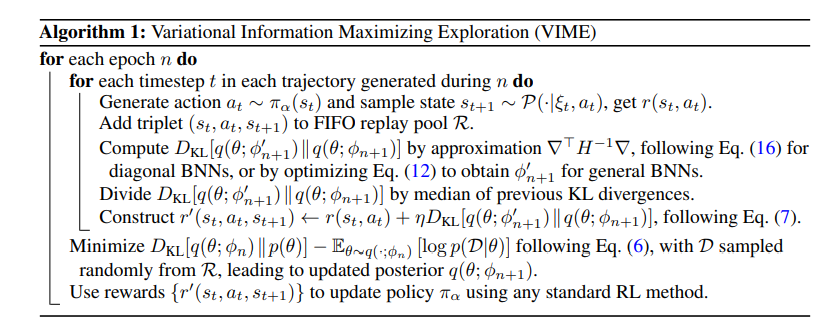

In [1]:
from IPython.display import Image
Image('vime algo.PNG')

Here we call functions from the `bnn.py` and `curiosity.py` files
`curiosity.py` implements the exploration strategy based on Taking actions that increase your knowledge about the world (the environment).
`bnn.py` creates the functions necessary for the creation of the Bayesian Neural Network.


In [ ]:
!pip install keras==2.2.4
!pip install scikit-learn==0.19.2
!pip install tensorflow==1.15.0

ERROR: tensorflow 2.7.0 has requirement keras<2.8,>=2.7.0rc0, but you'll have keras 2.2.4 which is incompatible.



  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


  ERROR: Command errored out with exit status 1:
   command: 'C:\ProgramData\Anaconda3\python.exe' -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'C:\\Users\\harrazki\\AppData\\Local\\Temp\\10\\pip-install-djwhh5d9\\scikit-learn\\setup.py'"'"'; __file__='"'"'C:\\Users\\harrazki\\AppData\\Local\\Temp\\10\\pip-install-djwhh5d9\\scikit-learn\\setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d 'C:\Users\harrazki\AppData\Local\Temp\10\pip-wheel-4fv98bjh'
       cwd: C:\Users\harrazki\AppData\Local\Temp\10\pip-install-djwhh5d9\scikit-learn\
  Complete output (617 lines):
  Partial import of sklearn during the build process.
  blas_opt_info:
  blas_mkl_info:
  No module named 'numpy.distutils._msvccompiler' in numpy.distutils; trying from distutils
  customize MSVCCompiler
    libraries mkl_rt not found in ['C:/ProgramData/Anaconda3\\Library\\l

  Running setup.py clean for scikit-learn
Failed to build scikit-learn
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
    Running setup.py install for scikit-learn: started
    Running setup.py install for scikit-learn: finished with status 'error'
  Rolling back uninstall of scikit-learn
  Moving to c:\programdata\anaconda3\lib\site-packages\scikit_learn-1.0.2.dist-info\
   from C:\ProgramData\Anaconda3\Lib\site-packages\~cikit_learn-1.0.2.dist-info
  Moving to c:\programdata\anaconda3\lib\site-packages\sklearn\__check_build\
   from C:\ProgramData\Anaconda3\Lib\site-packages\sklearn\~_check_build
  Moving to c:\programdata\anaconda3\lib\site-packages\sklearn\__init__.py
   from C:\Users\harrazki\AppData\Local\Temp\10\pip-uninstall-1x1_2ojw\__init__.py
  Moving to c:\programdata\anaconda3\lib\site-packages\sklearn\__pycache__\
   from C:\ProgramData\Anaconda

  customize GnuFCompiler
  Could not locate executable g77
  Could not locate executable f77
  customize IntelVisualFCompiler
  Could not locate executable ifort
  Could not locate executable ifl
  customize AbsoftFCompiler
  Could not locate executable f90
  customize CompaqVisualFCompiler
  Could not locate executable DF
  customize IntelItaniumVisualFCompiler
  Could not locate executable efl
  customize Gnu95FCompiler
  Could not locate executable gfortran
  Could not locate executable f95
  customize G95FCompiler
  Could not locate executable g95
  customize IntelEM64VisualFCompiler
  customize IntelEM64TFCompiler
  Could not locate executable efort
  Could not locate executable efc
  customize PGroupFlangCompiler
  Could not locate executable flang
  don't know how to compile Fortran code on platform 'nt'
    NOT AVAILABLE
  
  atlas_3_10_blas_threads_info:
  Setting PTATLAS=ATLAS
    libraries tatlas not found in ['C:\\ProgramData\\Anaconda3\\lib', 'C:\\', 'C:\\ProgramData\\Anac

    copying sklearn\linear_model\base.py -> build\lib.win-amd64-3.8\sklearn\linear_model
    copying sklearn\linear_model\bayes.py -> build\lib.win-amd64-3.8\sklearn\linear_model
    copying sklearn\linear_model\coordinate_descent.py -> build\lib.win-amd64-3.8\sklearn\linear_model
    copying sklearn\linear_model\huber.py -> build\lib.win-amd64-3.8\sklearn\linear_model
    copying sklearn\linear_model\least_angle.py -> build\lib.win-amd64-3.8\sklearn\linear_model
    copying sklearn\linear_model\logistic.py -> build\lib.win-amd64-3.8\sklearn\linear_model
    copying sklearn\linear_model\omp.py -> build\lib.win-amd64-3.8\sklearn\linear_model
    copying sklearn\linear_model\passive_aggressive.py -> build\lib.win-amd64-3.8\sklearn\linear_model
    copying sklearn\linear_model\perceptron.py -> build\lib.win-amd64-3.8\sklearn\linear_model
    copying sklearn\linear_model\randomized_l1.py -> build\lib.win-amd64-3.8\sklearn\linear_model
    copying sklearn\linear_model\ransac.py -> build\lib

ERROR: Could not find a version that satisfies the requirement tensorflow==1.15.0 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2)
ERROR: No matching distribution found for tensorflow==1.15.0


The following functions were initially located in the curiosity.py file.
However, we had to alter them because as they were coded, the `compile_vime_reward`function did not get the right inputs n the creation of the BNN class.
Indeed, the `extract_params`initially returned a filter and the outputs of this function were used as inputs for `compile_vime_reward`.

Therefore, we had to alter the `extract_params` so it would give out lists which is the appropriate type.


In [ ]:
def extract_params(bnn_weights,pred_loss,delta=0.01):
    rhos = list(filter(lambda p: p.name.endswith('bnn.rho'), bnn_weights))
    mus = list(filter(lambda p: p.name.endswith('bnn.mu'), bnn_weights))
    
    grad_mus = T.grad(pred_loss, mus)
    new_mus = [(mu - delta*grad_mu)
                for mu,grad_mu in zip(mus,grad_mus)]

    grad_rhos = T.grad(pred_loss, rhos)
    new_rhos = [(rho - delta*grad_rho)
                for rho,grad_rho in zip(rhos,grad_rhos)]
    
    for i in range(len(new_mus)):
        new_mus[i].name = 'new_mu'
    for i in range(len(new_rhos)):
        new_rhos[i].name = 'new_rho'
        
    mus,new_mus,rhos,new_rhos = map(lambda variables:T.concatenate([var.ravel() for var in variables]),
                                     [mus,new_mus,rhos,new_rhos])
        
    sigmas = T.log1p(T.exp(rhos))
    new_sigmas = T.log1p(T.exp(new_rhos))

    return mus,new_mus,sigmas,new_sigmas
    
def get_vime_reward(prev_mu,new_mu,prev_sigma,new_sigma):
    """KL for normal approximation"""
    kl = T.sum((new_sigma / prev_sigma) ** 2)
    kl += 2 * T.sum(T.log(prev_sigma))
    kl -= 2 * T.sum(T.log(new_sigma))
    kl += T.sum(((new_mu - prev_mu) / prev_sigma) ** 2)
    kl *= .5
    kl -= .5*new_sigma.shape[0]
    return kl


def get_r_vime_on_state(pred_weights,pred_loss,delta=0.01):
    """vime reward (single number) on state or states provided"""
    return get_vime_reward(*extract_params(pred_weights,pred_loss,delta=delta))

In [ ]:
from bnn import sample_output    
def compile_vime_reward2(l_prediction,l_prev_states,l_actions,weights,
                        get_loss = lambda pred,real: T.mean((pred-real)**2),
                        n_samples = 1,
                        delta=0.01,**kwargs):
    """compiles a function that predicts vime reward for each state in a batch"""
    prev_states = T.matrix("previous states")
    actions = T.ivector("actions")
    next_states = T.matrix("next states")
    if n_samples ==1:
        get_bnn = lambda state,action: lasagne.layers.get_output(l_prediction,
                                                     inputs={l_prev_states:state[None,:],
                                                             l_actions:action[None]},**kwargs)
    else:
        get_bnn = lambda state,action: sample_output(l_prediction,
                                                     input_dict={l_prev_states:state[None,:],
                                                                 l_actions:action[None]},
                                                     n_samples=n_samples,**kwargs)
        
    
    vime_reward_per_state,auto_updates = theano.map(lambda s,a,s_next: get_r_vime_on_state(weights,
                                                                              get_loss(get_bnn(s,a),s_next),
                                                                              delta),
                                       sequences=[prev_states,actions,next_states])
    
    return theano.function([prev_states,actions,next_states],vime_reward_per_state,
                           updates=auto_updates,allow_input_downcast=True)

Here, we setup our BNN class.
Bayesian neural networks were used and described for the first time by where it
was needed to have a probabilistic interpretation of neural networks that were considered
as ”black-box” till then. Instead of considering each weight as deterministic, we settle a
normal distribution on each weight as shown on next figure. This allows to prioritize few
data samples using the weights. A variational Bayesian method is applied to approximate
the integrals so as to provide an analytical approximation to the posterior probability of the
unobserved variables and to derive a lower bound for the marginal likelihood of the observed
data.

In [ ]:
from bnn import bbpwrap, NormalApproximation,sample_output
from lasagne.layers import EmbeddingLayer
import theano.tensor as T
@bbpwrap(NormalApproximation())
class BayesDenseLayer(DenseLayer):pass
@bbpwrap(NormalApproximation())
class BayesEmbLayer(EmbeddingLayer):pass

from curiosity import compile_vime_reward

class BNN:
    curiosity=0.01
    target_rho = 1
    
    l_state = InputLayer((None,state_size),name='state var')
    l_action = InputLayer((None,),input_var=T.ivector())

    l_action_emb = BayesEmbLayer(l_action,env.action_space.n, 3)    
    
    l_concat = lasagne.layers.concat([l_action_emb,l_state])
    
    l_dense = BayesDenseLayer(l_concat,num_units=50,
                              nonlinearity=lasagne.nonlinearities.tanh)
    
    l_out = BayesDenseLayer(l_dense,num_units=state_size,
                            nonlinearity=None)
        
    params = lasagne.layers.get_all_params(l_out,trainable=True)
        ###training###
    pred_states = lasagne.layers.get_output(l_out)
    next_states = T.matrix("next states")
    mse = lasagne.objectives.squared_error(pred_states,next_states).mean()
    
    
    reg = sum([lasagne.objectives.squared_error(rho,target_rho).mean() 
              for rho in lasagne.layers.get_all_params(l_out,rho=True)])
    
    loss = mse+ 0.01*reg
    
    updates = lasagne.updates.adam(loss,params)
    
    train_step = theano.function([l_state.input_var,l_action.input_var,next_states],
                                 loss,updates=updates)
    
    ###sample random sessions from pool###
    observations, = replay.observations
    actions, = replay.actions
    observations_flat = observations[:,:-1].reshape((-1,)+tuple(observations.shape[2:]))
    actions_flat = actions[:,:-1].reshape((-1,))
    next_observations_flat = observations[:,1:].reshape((-1,)+tuple(observations.shape[2:]))
    sample_from_pool = theano.function([],[observations_flat,actions_flat,next_observations_flat])
   
    
    ###curiosity reward### aka KL(qnew,qold)
    #get_vime_reward_elwise = compile_vime_reward(l_out,l_state,l_action,params,n_samples=10)
    get_vime_reward_elwise = compile_vime_reward2(l_out,l_state,l_action,params,n_samples=1) #change from initial code
    
    vime_reward_ma = 10.
    @staticmethod
    def add_vime_reward(observations,actions,rewards,is_alive,h0):
        assert isinstance(observations,np.ndarray)
        observations_flat = observations[:,:-1].reshape((-1,)+observations.shape[2:]).astype('float32')
        actions_flat = actions[:,:-1].reshape((-1,)).astype('int32')
        next_observations_flat = observations[:,1:].reshape((-1,)+observations.shape[2:]).astype('float32')

        vime_rewards = BNN.get_vime_reward_elwise(observations_flat,actions_flat,next_observations_flat)
        vime_rewards = np.concatenate([vime_rewards.reshape(rewards[:,:-1].shape),
                                       np.zeros_like(rewards[:,-1:]),], axis=1)
        #normalize by moving average
        BNN.vime_reward_ma = 0.99*BNN.vime_reward_ma + 0.01*vime_rewards.mean()
        
        surrogate_rewards = rewards + BNN.curiosity/BNN.vime_reward_ma*vime_rewards
        return (observations,actions,surrogate_rewards,is_alive,h0)

# Training loop

Now that everything is ready, we can train our model.

In [ ]:
#starting epoch
epoch_counter = 1

#full game rewards
rewards = {epoch_counter:untrained_reward}

In [ ]:
#pre-fill pool
from tqdm import tqdm
for i in tqdm(range(1000)):
    pool.update(SEQ_LENGTH,append=True,preprocess=BNN.add_vime_reward)

#pre-train BNN (mitigate training lag on first iterations where BNN is not acting in the best behavior)
for i in tqdm(range(1000)):
    BNN.train_step(*BNN.sample_from_pool())


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [17:03<00:00,  1.02s/it]


We ran our algorithm only on 100 iterations because it took very long (4 hours).

Ideally, we would like to train it on more iterations but this could not be done with acceptable times.

The long computation time might come from the way the algorithm was written and maybe it could be optimized in order to reduce it. This also might come from our local machines which are not very performent. The very long running time suggests a stability issue that needs fixing.

Either way, it would have been more interesting to see how using a larger number of iterations affects the results.

In [ ]:
#the loop may takes very long to run

loss = 0
for i in tqdm(range(100)):    
    
    
    #train
    for i in range(10):
        pool.update(SEQ_LENGTH,append=True,preprocess=BNN.add_vime_reward)

    for i in range(10):
        loss = loss*0.99 + train_step()*0.01
    
    for i in range(10):
        BNN.train_step(*BNN.sample_from_pool())

    
    if epoch_counter%10==0:
        #average reward per game tick in current experience replay pool
        pool_mean_reward = np.average(pool.experience_replay.rewards.get_value()[:,:-1],
                                      weights=1+pool.experience_replay.is_alive.get_value()[:,:-1])
        pool_size = pool.experience_replay.rewards.get_value().shape[0]
        print("iter=%i\tepsilon=%.3f\treward/step=%.5f\tpool_size=%i\tvime ma=%.5f"%(epoch_counter,
                                                         epsilon.get_value(),
                                                         pool_mean_reward,
                                                         pool_size,
                                                         BNN.vime_reward_ma))
        

    ##record current learning progress and show learning curves
    if epoch_counter%10 ==0:
        n_games = 10
        epsilon.set_value(0)
        rewards[epoch_counter] = pool.evaluate( record_video=False,n_games=n_games,verbose=False)
        print("Current score(mean over %i) = %.3f"%(n_games,np.mean(rewards[epoch_counter])))
        epsilon.set_value(0.05)
    
    
    epoch_counter  +=1


  2%|█▌                                                                             | 2/100 [05:21<4:22:30, 160.72s/it]

iter=30	epsilon=0.000	reward/step=-0.98796	pool_size=1311	vime ma=1.65207


  3%|██▎                                                                            | 3/100 [08:16<4:30:19, 167.22s/it]

Current score(mean over 10) = -200.000


 12%|█████████▎                                                                    | 12/100 [32:39<4:00:48, 164.19s/it]

iter=40	epsilon=0.050	reward/step=-0.98792	pool_size=1411	vime ma=1.48033


 13%|██████████▏                                                                   | 13/100 [35:39<4:04:59, 168.96s/it]

Current score(mean over 10) = -200.000


 22%|█████████████████▏                                                            | 22/100 [59:53<3:32:00, 163.09s/it]

iter=50	epsilon=0.050	reward/step=-0.98792	pool_size=1511	vime ma=1.31546


 23%|█████████████████▍                                                          | 23/100 [1:02:53<3:35:53, 168.23s/it]

Current score(mean over 10) = -200.000


 32%|████████████████████████▎                                                   | 32/100 [1:27:01<3:01:16, 159.95s/it]

iter=60	epsilon=0.050	reward/step=-0.98783	pool_size=1611	vime ma=1.27632


 33%|█████████████████████████                                                   | 33/100 [1:29:54<3:03:13, 164.08s/it]

Current score(mean over 10) = -200.000


 42%|███████████████████████████████▉                                            | 42/100 [1:53:49<2:34:47, 160.14s/it]

iter=70	epsilon=0.050	reward/step=-0.98776	pool_size=1711	vime ma=1.26994


 43%|████████████████████████████████▋                                           | 43/100 [1:56:44<2:36:29, 164.73s/it]

Current score(mean over 10) = -200.000


 52%|███████████████████████████████████████▌                                    | 52/100 [2:20:46<2:08:13, 160.28s/it]

iter=80	epsilon=0.050	reward/step=-0.98771	pool_size=1811	vime ma=1.19695


 53%|████████████████████████████████████████▎                                   | 53/100 [2:23:39<2:08:35, 164.16s/it]

Current score(mean over 10) = -200.000


 62%|███████████████████████████████████████████████                             | 62/100 [2:47:34<1:40:54, 159.32s/it]

iter=90	epsilon=0.050	reward/step=-0.98771	pool_size=1911	vime ma=1.08937


 63%|███████████████████████████████████████████████▉                            | 63/100 [2:50:28<1:40:54, 163.64s/it]

Current score(mean over 10) = -200.000


 72%|██████████████████████████████████████████████████████▋                     | 72/100 [3:14:38<1:14:46, 160.21s/it]

iter=100	epsilon=0.050	reward/step=-0.98763	pool_size=2011	vime ma=1.08442


 73%|███████████████████████████████████████████████████████▍                    | 73/100 [3:17:30<1:13:38, 163.65s/it]

Current score(mean over 10) = -200.000


 82%|███████████████████████████████████████████████████████████████▉              | 82/100 [3:42:00<49:31, 165.06s/it]

iter=110	epsilon=0.050	reward/step=-0.98762	pool_size=2111	vime ma=1.02055


 83%|████████████████████████████████████████████████████████████████▋             | 83/100 [3:45:01<48:08, 169.90s/it]

Current score(mean over 10) = -200.000


 92%|███████████████████████████████████████████████████████████████████████▊      | 92/100 [4:09:39<22:00, 165.08s/it]

iter=120	epsilon=0.050	reward/step=-0.98759	pool_size=2211	vime ma=0.94612


 93%|████████████████████████████████████████████████████████████████████████▌     | 93/100 [4:12:32<19:33, 167.60s/it]

Current score(mean over 10) = -200.000


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [4:31:28<00:00, 162.88s/it]


In [ ]:
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda kv: (kv[0]))) # we had to change this line as well as python does not allow this syntax

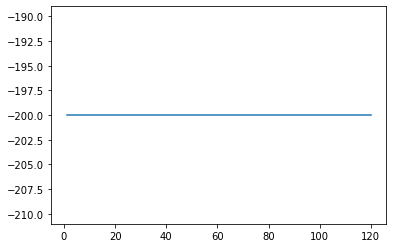

In [ ]:
plt.plot(iters,list(map(np.mean,session_rewards)))

We see here that the rewards do not change on the few number of iterations that we have used our model on. Maybe using more iterations would have allowed to see the rewards change and improve them.

We now wish to visualize the predicte state values.

Text(0, 0.5, 'speed')

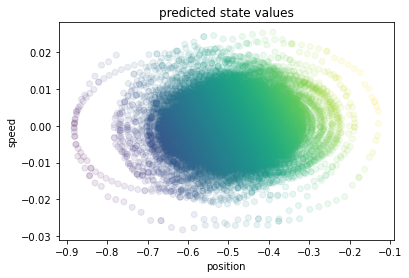

In [ ]:

_,_,_,_,(pool_policy,pool_V) = agent.get_sessions(
    pool.experience_replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,)

plt.scatter(
    *pool.experience_replay.observations[0].get_value().reshape([-1,2]).T,
    c = pool_V.ravel().eval(),
    alpha = 0.1)
plt.title("predicted state values")
plt.xlabel("position")
plt.ylabel("speed")

We see here that the algorithm takes on a wide range of positions that it wants to explore. Using more iterations would have allowed to reach convergence.

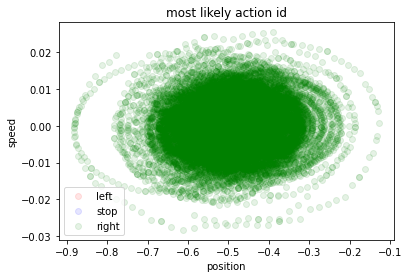

In [ ]:
obs_x,obs_y = pool.experience_replay.observations[0].get_value().reshape([-1,2]).T
optimal_actid = pool_policy.argmax(-1).ravel().eval()

for i in range(3):
    sel = optimal_actid==i
    plt.scatter(obs_x[sel],obs_y[sel],
                c=['red','blue','green'][i],
                alpha = 0.1,label=action_names[i])
    
plt.title("most likely action id")
plt.xlabel("position")
plt.ylabel("speed")
plt.legend(loc='best')

The most likely actions are plotted and we see a similar profile as above which suggests a good approach thanks to the first iterations of VIME.